# Analisi dei dati ottenuti dalla applicazione di controllo distribuito

Innanzitutto bisogna chiedersi perché è necessario parlare di controllo della rete e delle topologie. È necessario parlare
di controllo ottimo della rete perché è la procedura che mi permette di garantire un'operazione corretta ed affidabile
della rete. I problemi di stabilità della rete e la necessità di controllo nella rete, nasce dalla natura del mezzo fisico
con cui interconnetto i vari device e dalla gestione dell'accesso al mezzo fisico. Il controllo della rete può essere
fatto in più modi attraverso:
* gestione dei metodi di accesso del canale
* gestione dei traffici che generano un'evoluzione dello stato del sistema

La gestione del controllo della rete attraverso i metodi di accesso al canale è una macro categoria di cui non mi occupo.
Per quanto riguarda il controllo della rete mi occupo del problema a livello E2E nell'ottima di controllo della
congestione e controllo di flusso (primariamente attraverso TCP).

Espongo l'analisi dei dati e le conclusioni che ho tratto fino ad ora con le simulazioni.

## Ipotesi e statement del problema
Ipotizzo che la trasmissione dei dati soprattutto nel piano di controllo della mia rete segua una distribuzione heavy-
tailed e che al limite converga ad una distribuzione stabile.

L'ipotesi è duplice:
* Il mio sistema genera dati nel piano di controllo con una distribuzione heavy-tailed
* Il processo che genera dati se osservato per un tempo sufficientemente lungo converge ad una distribuzione stabile

Il problema del primo punto è che fare un fit per una distribuzione heavy-tailed è estremamente complicato e i dettagli
matematici sono particolarmente tecnici. Da un punto di vista numerico i test $ \chi^2 $ impone di conoscere la
distribuzione sottostante così che possa verificare le "discrepanze" osservate siano sotto un certo valore. Questa
distribuzione sottostante di probabilità non ce l'ho, non posso andare "a tentoni" provando tutte le varie distribuzioni
fino a che no trovo quella con uno score minimo. Non posso neanche fare un fit con la log-verosimiglianza cercando con un
MLE di trovare i vari parametri che compongono le distribuzioni, poiché i dati finiscono in regioni inammissibili dei
metodi di ottimizzazione e quindi i valori calcolati sono spesso inaffidabili o con bound di incertezza così elevati che
rendono inutili le stime prodotte.

Dunque per dimostrare il primo punto posso solo osservare che i dati di lunghezza dei pacchetti sulle reti dati (eg Internet)
sono sempre stati classificati come distribuiti secondo pdf heavy-tailed. Il metodo usato solitamente è quello di fare
una mean-excess analysis e vedere com'è fatta la distribuzione dei valori eccezionali. Un secondo metodo empirico che uso
io in virtù del fatto che il processo sottostante è calssificabile come heavy-tailed, vado a cercare conferma della mia
ipotesi guardando la media mobile a corto termine e poi allungando la lunghezza del filtro moving average. Se ottengo un
con tempovariante e con un running average che mostra un trend questo è una condizione necessaria all'essere heavy tailed.

## Statement del problema

Ipotizzo che una rete di sensori in ambito mobile IoT abbia bisogno di una applicazione di rete per il controllo ottimo:
* del traffico
* della topologia
* delle congestioni
* degli sprechi in termini di banda/energia/slot-temporali

Il problema principale deriva dal fatto che il mezzo trasmissivo che sto usando è wireless ed usando un modello a livello
fisico scopro che ci sono interferenze in ambienti in cui uso radio-propagazione. Solitamente questi problemi vengono
chiamati come il problema del terminale nascosto e terminale scoperto. La soluzione proposta per questi due problemi
"classici" è quella di usare un controllo centralizzato oppure l'uso di pacchetti RTS/CTS. Ognuno di questi metodi ha i
suoi pregi e difetti. Mi concentro sul metodo del controllo centralizzato poiché è quello meno investigato di tutti in
ambiente sensori mobile IoT.

### Esempio di non stazionierità del segnale traffico medio

Nel seguente dataset raccolto da un insieme di dispositivi con un'applicazione di controllo simile a quella usata nelle
simulazioni del network forming. Dai risultati esposti con questo dataset ed il dataset delle simulazioni della tesi
vediamo la conferma di ciò che viene riportato nell'[articolo](http://www.cs.unc.edu/Research/dirt/proj/marron/VarHeavyTails/VarHeavyTail1.pdf).
Nell'articolo viene dimostrato come traffici di tipo HTTP o simili siano distribuiti secondo pmf con heavy-tails. Nell'
articolo menzionato viene data una modellazione dettagliata di quello che è la distribuzione del traffico. **Non** ripeto
l'analisi fatta da loro, semplicemente è un'osservazione della ecdf e tramite osservazione affermano che il traffico segue
le loro previsioni. Nella sezione dell'articolo citato viene data una dimostrazione delle proprietà delle pmf heavy-tailed
e con una stima cercano di ottenere l'indice di coda che caratterizza il traffico.
La mia analisi è molto più semplice in questo documento, mi limito a osservare che per il teorma limite centrale della
probabilità io so che:
$\displaystyle P[X_1+X_2+X_3...] \sim N(\mu, \sigma) $ dove $ \mu = \frac{1}{N}(\sum_{i=1}^N X_i) $ ciò che questo dice
è che la somma di N variabili aleatorie convergerà ad una gaussiana con $\mu$ la media campionaria. Questo è vero in una
moltitudine di casi, tra l'altro, la media campionaria è un'ottmo stimatore dela valore medio di una moltitudine di altre
distribuzioni di probabilità. Perché concentrarsi tanto sulle distribuzioni heavy-tailed? Perché il teorma limite della
probabilità **non** vale nel caso delle distribuzioni fat-tailed. Per convincersene basta osservare che per le funzioni
regolarmente non variabili la "probabilità estrema" e cioè la probabilità che si avverino eventi "estremi" è molto più
probabile che l'evento normale. Questo si può vedere osservando che una distribuzione fat-tailed se ne definiamo la
*survival function* $ F $ din una v.a. $ X $ tale che $ \overline{F}(X) = 1-F(X)=Prob[X>x] $ allora indico con la seguente
scrittura $ \overline{F}(X) \sim x^{-\alpha}, x \to \infty $ per indicare che
$\lim_{x\to \infty} \frac{\overline{F}(X)}{x^{-\alpha}} \to 1 $. Qui $\alpha$ è il tail index cioè la velocità con cui la
probabilità tende a un valore maggiore di $ x $ con $ x\to \infty $. Nelle distribuzioni per cui vale il teorma limite
centrale questo tasso $ \alpha $ è polinomiale, nelle distribuzioni fat-tailed è *subesponenziale*. Questo cosa comporta?
Comporta il fatto che: <br>
$\displaystyle P[X_1+X_2+X_3...] \sim P[max(X_1, X_2, X_3, 0...) > x], x \to \infty $ <br>
Tutto ciò che viene descritto qui è soltanto un *limiting behavior* cioè caratteristiche che si manifestano solo al limite.
Il risultato di tutto è il seguente:
* Le medie storiche sono *inaffidabili* per la predizione
* Le differenze fra due predizioni successivamente sempre più "lontane" non decresce
* Il rapporto di due valori record successivi fra di loro non descesce
* La media di eventi in eccesso rispetto a una soglia aumenta all'aumentare della soglia
* L'incertezza dello stimatore statistico del comportamento medio di $n$ variabili aleatorie è simile a quelle originali
* I coefficienti delle regressioni che proviamo in molti casi danno risultati errati

Un errore molto comune e molto grave che viene commesso è quello di basare previsioni di dati di risk return nelle operazioni
di trading finanziario usano la teoria "classica" invece che le distribuzioni fat-tailed e le loro cautele necessarie (si
veda il libro del dott. Taleb al riguardo)

Ritornando ai dati, ciò che possiamo dire è che in un campione finito della popolazione, necessariamente i miei stimatori
convergeranno a qualcosa di finito e le loro deviazioni standard, per quanto elevate, saranno finite. Ciò non dovrebbe
trarre in inganno, poiché i miei stimatori mi possono dire che convergo a qualcosa quando in realtà sto inseguendo una
quantità che diverge... Pensiamo ad esempio a stimare la media di una distribuzione di Cauchy. La distibuzione di Cauchy
è una delle distribuzioni più "classiche" fra quelle fat-tailed in quanto ha una forma chiusa abbastanza usabile per le
stime a massima verosimiglianza. La media della distribuzione di Cauchy *non* è definità poiché l'integrale non converge,
lo stimatore MLE sì converge... A cosa converge? Ad un valore nullo, ma se non conosco la distribuzione sottostante io non
saprei che convergo a un valore spazzatura, per questo motivo bisogna fare molta attenzione alle distibuzioni fat-tailed
in quanto convergono a delle distribuzioni *stabili* piuttosto che a una gaussiana.

### Osservazione dei dati

Il seguente dataset come anticipato mostra i "sintomi" di distribuzioni fat-tailed, **non** faccio un'analisi approfondita
in questo documento ma mi limiterò a enunciare i risultati in modo qualitativo. In particolare:
* Nel caso che la media mobile mostri chiaramente segnali di trend è plausibile ipotizzare una distribuzione fat-tailed


    Utilizzo un data set spesso usato per dimostrare queste proprietà, non l'ho raccolto io

In realtà non è che nei miei dati ci sia un trend è solo che sto usando lo stimatore sbagliato. Nel dataset riportato
si osserva proprio questo. Il dataset seguente è un dataset di parametri economici preso dal progetto GECON:

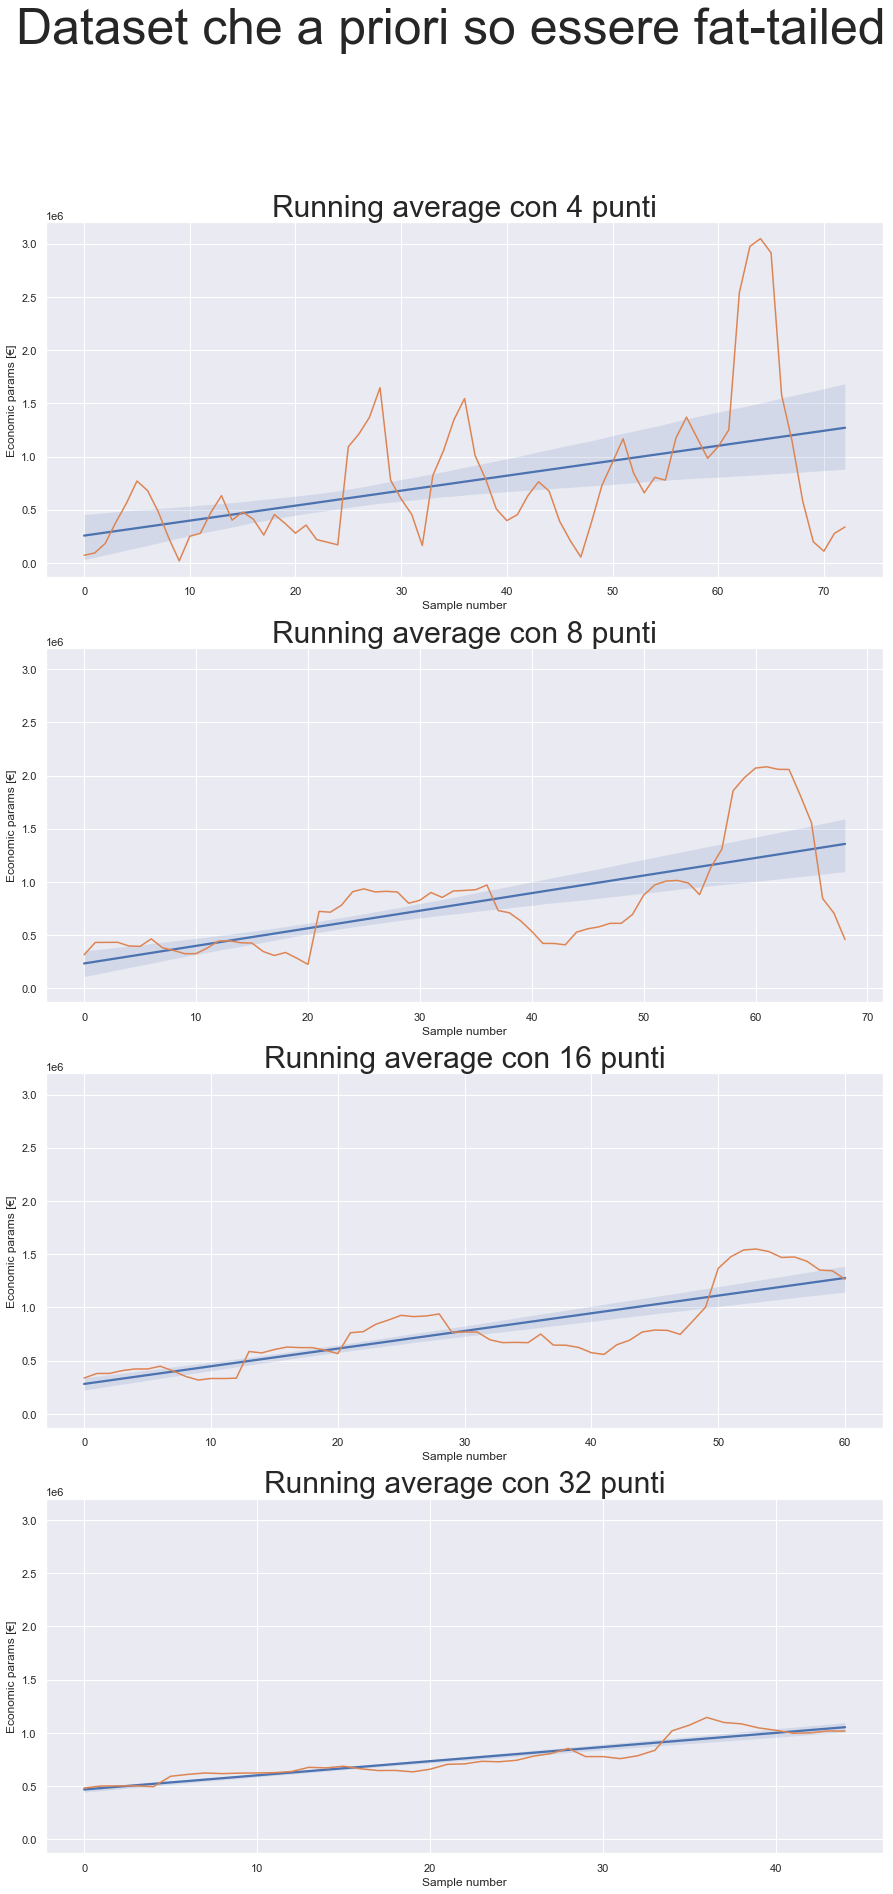

In [1]:
import copy
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas

ds = pandas.read_csv("../data/GECON dataset.csv")
copyds = copy.deepcopy(ds)


def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


windows = ["4", "8", "16", "32"]
sns.set()
fig, axes = plt.subplots(len(windows), 1, figsize=(15, 30), sharey=True)
x = 0
sns.set()
plt.suptitle("Dataset che a priori so essere fat-tailed",
             fontproperties=matplotlib.font_manager.FontProperties(size=50))
for win_length in windows:
    vsct = moving_average(copyds["Bps"], int(win_length))
    axes[x].set_title(f"Running average con {win_length} punti",
                      fontproperties=matplotlib.font_manager.FontProperties(size=30))
    df = pandas.DataFrame({"y": vsct, "x": list(range(len(vsct)))})
    sns.regplot(x="x", y="y", data=df, scatter=False, ax=axes[x])
    p = sns.lineplot(x="x", y="y", data=df, ax=axes[x])
    p.set(xlabel="Sample number", ylabel="Economic params [€]")
    x += 1


Dai plot sopra, nonostante abbia fatto una media mobile con una lunghezza della finestra notevole ripsetto al numero di
campioni, questo non è risultato sufficiente a togliere i "trend" nei dati. Questa caratteristica che abbiamo osservato
qualitativamente è un segnale di comportamento self-similar caratteristico nelle reti dati. Ripropongo la stessa
visualizzazione con i dati della rete:

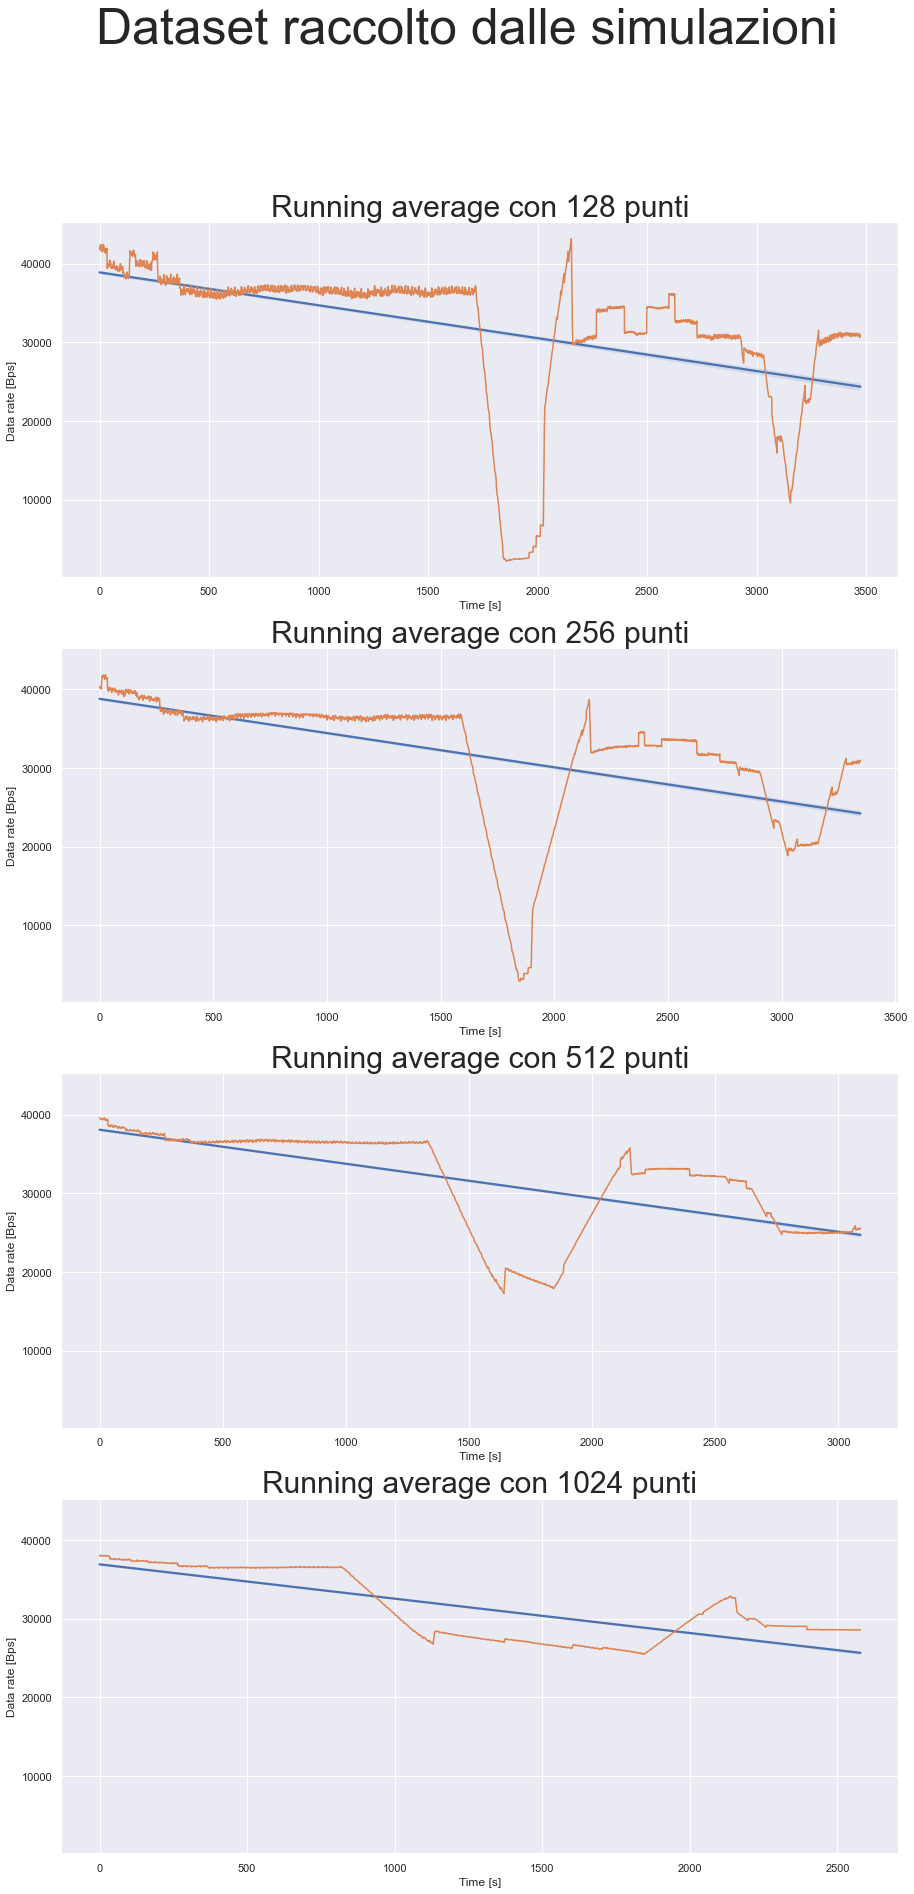

In [2]:
ds = pandas.read_csv("../data/1 ora eserczio rete con piano lavoro REST.csv")
net_ds = copy.deepcopy(ds)
# indexNames = net_ds[net_ds['Bps'] < 1000].index
# net_ds.drop(indexNames, inplace=True)
windows = ["128", "256", "512", "1024"]
sns.set()
fig, axes = plt.subplots(len(windows), 1, figsize=(15, 30), sharey=True)
x = 0
sns.set()
plt.suptitle("Dataset raccolto dalle simulazioni",
             fontproperties=matplotlib.font_manager.FontProperties(size=50))
for win_length in windows:
    vsct = moving_average(net_ds["Bps"], int(win_length))
    axes[x].set_title(f"Running average con {win_length} punti",
                      fontproperties=matplotlib.font_manager.FontProperties(size=30))
    df = pandas.DataFrame({"y": vsct, "x": list(range(len(vsct)))})
    sns.regplot(x="x", y="y", data=df, scatter=False, ax=axes[x])
    p = sns.lineplot(x="x", y="y", data=df, ax=axes[x])
    p.set(xlabel="Time [s]", ylabel="Data rate [Bps]")
    x += 1

Il fatto che questi dati suggeriscano una presenza di distribuzioni di tipo fat-tailed induce a riflettere nel trarre le
conclusioni. Una rete dati mostra un comportamento fat-tailed, dunque al limite tenderà ad una distribuzione *stable*.
Questo che conseguenze ha nella pratica? Ragioniamo facendo uso di un ulteriore strumento: la teoria dei valori estremi.
Secondo questa congettura nelle distribuzioni fat-tailed si vede un'applicazione del detto:"al peggio non c'è mai fine".
Questo lo possiamo dire ragionando sui dati degli uragani negli USA i quali sono distribuiti in modo fat-tailed. Per quanto
riguarda i dati distribuiti in modo fat-tailed e le loro proprietà applicati al dataset degli uragani, possiamo dire che
usando la distribuzione degli eventi eventi in eccesso definita come $ P[X>x|X>u] $ possiamo dire che in tutti i dataset
si osserva che $\displaystyle E(P[X>x|X>u]) $ per la linearità dell'operatore media possiamo dire che se fissata una soglia
$ u $ e volendo, fra tutti i valori oltre la soglia, cercare gli eventi estremi, possiamo dire che la loro media sarà
sempre e comunque maggiore della soglia. Tutto ciò applicato agli uragani ci permette di dire che fissata una soglia di
danni economici causati da questi uragani, presa una certa soglia, la media dei danni sarà maggiore di quella soglia. Da
questo possiamo dire che guardando agli uragani non è possibile trovare ujna soglia $ u $ tale che $E(P[X>x|X>u]) < u $
e questo è vero anche se spingo sempre più la soglia dei danni, al peggio non c'è mai fine...

Questo principio vale per tutti i dati distribuiti secondo pmf fat-tailed, dunque anche per i dati che ho raccolto nella
rete con controllo 1-hop. Anche le altre reti di sensori wifi generali si comportano in questo modo, dimostro la precedente
con un precedente dataset raccolto in una rete wifi non infrastrutturata con un'applicazione di generazione dati UDP.

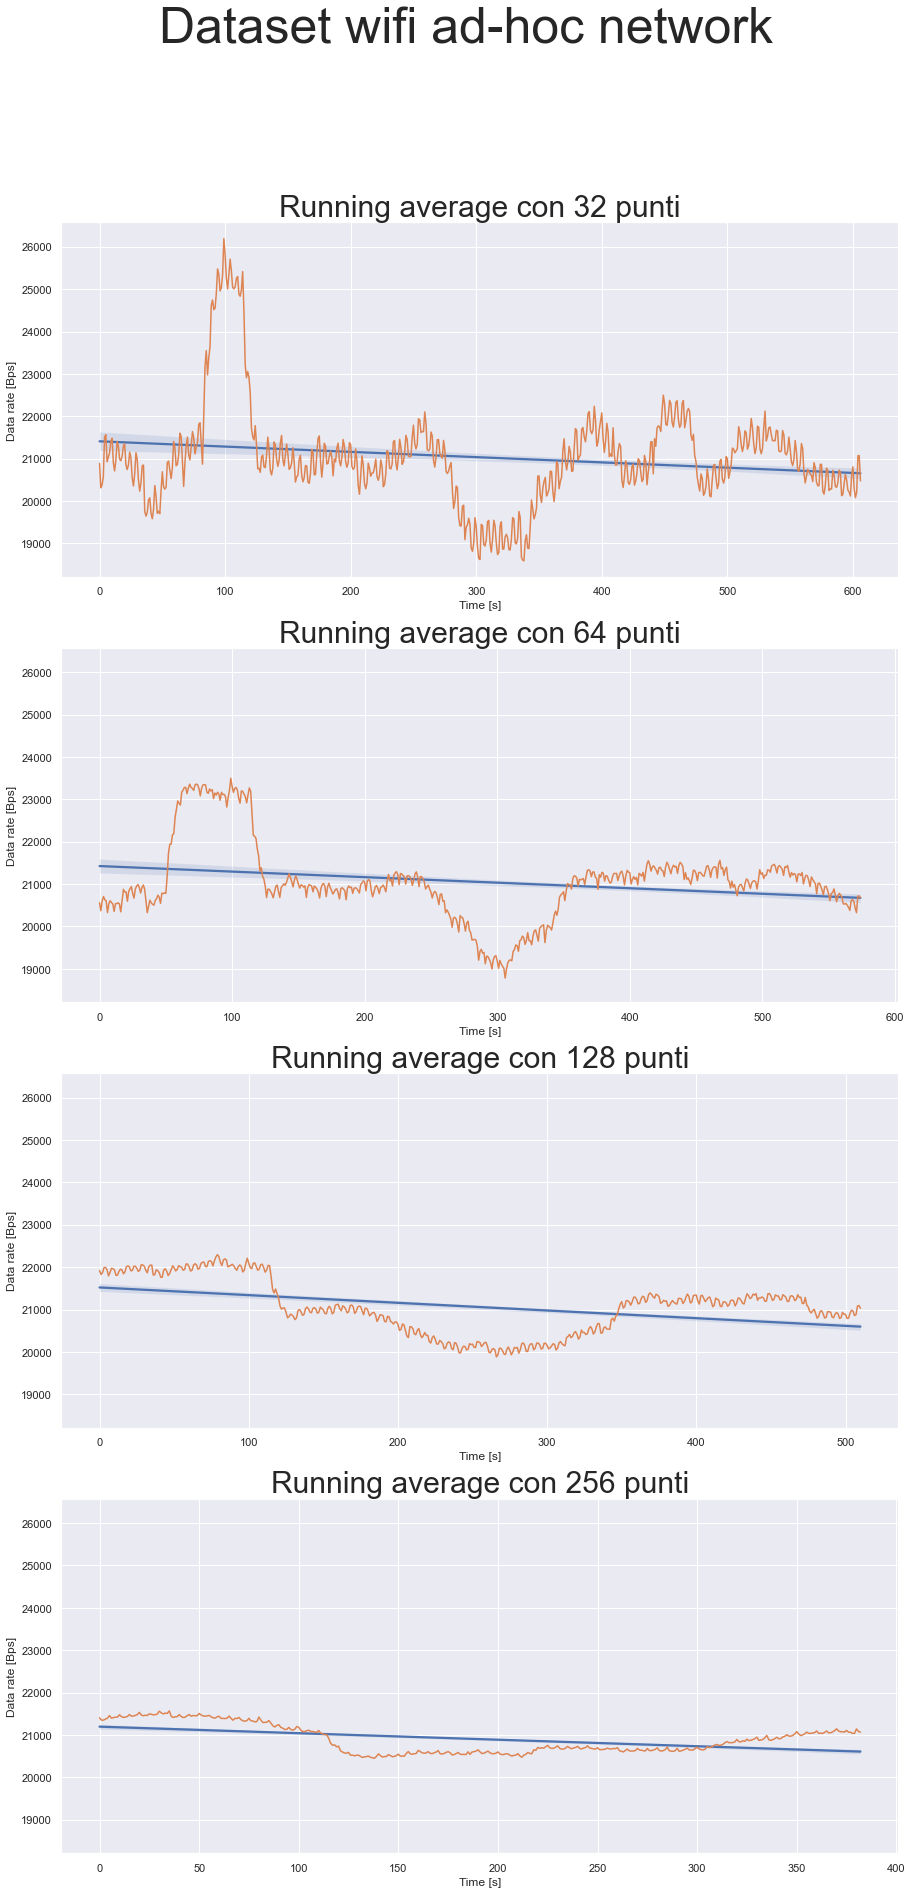

In [3]:
ds = pandas.read_csv("../data/capture_wifi.csv")
net_ds = copy.deepcopy(ds)
# indexNames = net_ds[net_ds['Bps'] < 1000].index
# net_ds.drop(indexNames, inplace=True)
windows = ["32", "64", "128", "256"]
sns.set()
fig, axes = plt.subplots(len(windows), 1, figsize=(15, 30), sharey=True)
x = 0
sns.set()
plt.suptitle("Dataset wifi ad-hoc network",
             fontproperties=matplotlib.font_manager.FontProperties(size=50))
for win_length in windows:
    vsct = moving_average(net_ds["Bps"], int(win_length))
    axes[x].set_title(f"Running average con {win_length} punti",
                      fontproperties=matplotlib.font_manager.FontProperties(size=30))
    df = pandas.DataFrame({"y": vsct, "x": list(range(len(vsct)))})
    sns.regplot(x="x", y="y", data=df, scatter=False, ax=axes[x])
    p = sns.lineplot(x="x", y="y", data=df, ax=axes[x])
    p.set(xlabel="Time [s]", ylabel="Data rate [Bps]")
    x += 1


### Conlusioni analisi empirica dei dati

La cosa principale che capiamo da questi grafici e le formule esposte è il fatto che: il fatto che al peggio non ci sia
mai fine vale anche nella rete. Questo lo capiamo in quanto i dataset appartengono a categorie di applicazioni generiche
che sono distribuite, tutte quante, secondo distribuzioni fat-tailed. Dunque, anche per le reti vale la proprietà
riguardante la excess distribution per la quale fissata una soglia di throughput lungo il control plane, la media dei
throughput osservati nella excess distribution cioè tali per cui $ X>u $ la media di questi throughput osservati sarà
sempre maggiore della soglia. Peggio ancora, più spingo la soglia dei throughput e anche lì la media dei dati osservati
sarà in ogni caso maggiore della soglia, in teoria anche se la soglia viene trascinata al limite... Quest'ultima cosa
avviene ad esempio nei casi di broadcast storm.

Come dimostrazione finale mostro un fit fatto con la survivor function della distribuzione fat-tailed dei miei dati ed
una distribuzione fat-tailed del tipo Pareto generalizzata <img height="400" src="../assets/fit.jpg" width="400"/>

## Modello della rete

Adesso analizziamo una applicazione di controllo della rete, questo per mitigare le problematiche esposte prima attraverso
la distribuzione dei dati.

Una prima soluzione è quella di identificare gli eventi estremi e risolvere quei casi. Ragionanando in questo modo possiamo
pensare che l'evento catastrofico da risolvere siano i broadcast storm dovuti ai cicli nella rete.

    soluzione: eliminiamo i cicli ed usiamo STP

Questa soluzione non tiene conto della stabilità della rete... È possibile dimostrare che una rete con UDP è modellabile
dal punto di vista della propagazione dati come un sistema lineare e quindi posso fare un'analisi della stabilità.
Ciò che si può dimostrare è che una rete con UDP è un sistema stabile ma che in generale ha caratteristiche di margine di
fase molto fragili, basta poco per far "scoppiare" la rete. Per convicnersene basti pensare cagli attacchi "smurf" cioè
di amplificazione, principalmente utilizzano protocolli trasporto che non prevedono controlli distribuiti sul carico immesso
nella rete (ad esempio broadcast ping). Col protocollo TCP risolviamo il problema, grazie al protocollo e ai suoi algoritmi
di gestione della congestione (livello IP) e del flusso (sliding window), non sono soluzioni definitive in quanto non
effettuo un'ottimizzazione congiunta ma opero su due livelli diversi, ma è comunque un buon risultato.

Quest'ultima frase significa che nel piano di controllo di una rete di sensori SDN è necessario usare protocolli di
trasmissione con qualche meccanismo di controllo della congestione e di controllo del flusso, anche basilari. Se queste
precazioni non vengono intraprese, ci esponiamo al rischio di overflowing dei dispositivi. Questo perché nel piano di controllo
ipotizzato nella simulazione, ho 1 hop di propagazione. Con unm modello del genere, nel caso peggiore trasmetterò un
numero $ o(n^2) $ pacchetti con $n$ numero di nodi. Il bound quadratico nel numero dei nodi si giustifica pensando che
qualunque pacchetto da qualunque nodo verrà ritrasmesso in ogni collegamento. Il caso peggiore è che ci sia un messaggio
per ogni collegamento e per ogni nodo, cioè $ \frac{n(n-1)}{2} \sim n^2 $ in pratica la situazione di una mesh.

Nello studio dell'applicazione di controllo della rete, intanto inizio studiando gli algoritmi di controllo distribuiti.
Principalmente gli algoritmi di controllo del carico su una rete sono di due tipi:
* Distribuito
* Centralizzato

Nel seguente paragrafo vediamo gli algoritmi distribuiti di controllo della rete e poi nell'ultimo paragrafo vediamo gli
algoritmi centralizzati e come li ho implementato nel controller Ryu.

Topologia: 


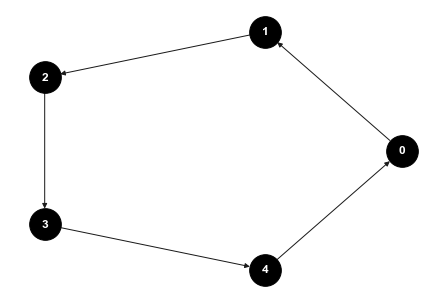

In [4]:
print("Topologia: ")
import matplotlib.pyplot as plt
import networkx as nx

G = nx.DiGraph()

for i in range(0, 5):
    G.add_node(i)

pos = nx.circular_layout(G)

G.add_edge(0, 1)
G.add_edge(1, 2)
G.add_edge(2, 3)
G.add_edge(3, 4)
G.add_edge(4, 0)

nx.draw(G, pos=pos, with_labels=True, font_weight='bold', node_size=1000, node_color='black', font_color='white')
plt.show()

Questo è il modello della rete ad anello che uso per far vedere quali sono alcuni problemi che possono nascere.
Supponiamo il traffico entri nel nodo $ i $ e lasci la rete attraverso il nodo $ [(i+1) mod n] +1 $. Indicando con $ x_i $
il rate del traffico che il nodo $ i $ offre alla rete ed indicando $ x_i' $ il rate del traffico nel collegamento col
nodo successivo allora abbiamo:

\begin{equation}
    \begin{cases}
      x_i = min(x_i, \frac{c_i}{x_i+x_{i-1}'})\\
      x_i'' = min(x_i', \frac{c_{i+1}}{x_i'+x_{i+1}}x_i')
    \end{cases}\
\end{equation}

Per semplicità ipotizzimo $ c_i = c $ ed $ x_i = x \quad \forall i \quad in \quad N $. A questo punto possiamo dire che
se $ x \leq c/2 $ allora non ci saranno perdite $ x = x' = x'' $ ed il throughput della rete sarà $ nx $. <br>
Altrimenti si può dire che:
<br>  $ x' = \frac{cx}{x+x'} $ ed ottengo $ x'=\frac{x}{2}(\sqrt{1+4\frac{c}{x}}-1) $ <br>
ed inoltre sempre dalle equazioni precedenti so che
<br> $ x'' = \frac{cx'}{x+x'} $ ed ottengo $ x''= c - \frac{x}{2}(\sqrt{1+4\frac{c}{x}} -1) $ <br>
uso l'approssimazione di Taylor al primo ordine ed ottengo $ x'' = \frac{c^2}{x} +o(\frac{1}{x}) $ dove $ o(\frac{1}{x}) $
denota tutti i termini di ordine superiore al secondo. Dunque si vede che $ \lim_{x\to\infty} x''=0 $ il rate dunque va
a zero ed anche il throughput andrà a zero, questo è il *congestion collapse*. Ogni device dovrà limitare la quantità di
traffico offerto alla rete, *ma come*?

## Efficienza ed equità

Suppondendo che ci sia qualche meccanismo per il controllo del traffico e che quindi le perdite siano trascurabili si ha
che: <br> $ x_n + x_i = c \quad \forall i \in [1 , n-1] $ dunque il throughput
$ \theta = (n-1)(c-x_n) + x_n = c(n-1) - x_n(n-2) $ <br> Dunque una streategia per aumentare il thorughput è quella di
spingere il traffico offerto da $ x_n \rightarrow 0 $, ma questo non è molto equo nei suoi confronti... C'è un altro modo
per garantire un uso completo delle risorse ed equo.

## Allocazione ottima delle risorse

Per ottimizzare l'allocazione delle risorse di rete per tutti gli utenti, possiamo ragionare:
* in termini di ottimizzazione distribuita
* dell'equilibrio di Nash in cui la rete si troverà a regime
* secondo i principi di ottimalità di Wardrop

Per l'analisi del problema delle ipotesi e della soluzione algoritmica si veda il seguente
[notebook](https://github.com/andi-ra/Optimization/blob/main/notebooks/frank-wolfe.ipynb).

A questo punto ragionando dell'ottimizzazione distribuita introduco la funzione ulitità $ U_i(x_i) $ che ogni device
produce per ogni info che trasmette. Ciò che voglio è massimizzare l'utilità dell'intero sistema. <br>
$ \displaystyle\max_{x_i \ge 0}\sum_{i \in \overline{S}} U_i(x_i) $. Questo è molto diverso rispetto al concetto di
system optimum descritto da Wardrop.
#### Ipotesi 1
Per ogni $ i \in \overline{S} $, $ U_i(x_i) $ è una funzione monotona crescente, liscia e convessa.

Sia $ x_i^*, i \in \overline{S} $ soluzione ottima del problema. Poiché per ipotesi la funzione è convessa e per le
proprietà del punto ottimo si ha che $\nabla U =0 $ e quindi <br>
$ \displaystyle\sum_{i \in \overline{S}} \nabla U_i(x_i^*)(x_i-x_i^*) \leq 0 $ <br> da questo punto in poi ragiono con
un'analisi del punto fisso $ x_i^* $. Riorganizzo i termini e posso dire: <br>
$ \displaystyle\sum_{i \in \overline{S}} \nabla U_i(x_i^*)x_i^*\frac{x_i-x_i^*}{x_i^*} \leq 0 $ <br> qual'è l'interpretazione
dei termini:
* $ \frac{x_i-x_i^*}{x_i^*} $ è il cambio marginale di rate di trasmissione della sorgente $ i $
* $ \nabla U_i(x_i^*)x_i^* $ può essere interpetato come la *fairness* della sorgente

L'ultima equazione ci dice la somma pesata dei cambi di rate di trasmissione in ogni utente è meno di zero.

### Proportional fairness

Scegliamo per esempio $ U_i(x_i)=w_ilogx_i $ con $ w_i \ge 0 $. La disequazione variazionale diventa: <br>
$ \displaystyle\sum_{i \in \overline{S}} w_i\frac{x_i-x_i^*}{x_i^*} \leq 0 $, dunque le variazioni di rate per ogni
utente pesati per la loro "importanza" sono non positivi.
#### Esempio
Sia data la rete in figura, chiamato anche **modello KP**

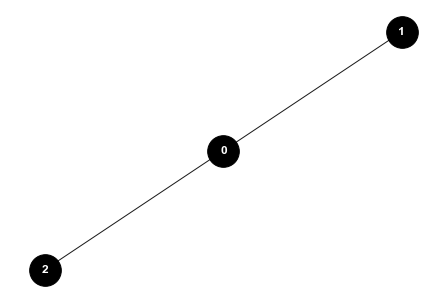

In [5]:
G = nx.Graph()
G = nx.Graph()

for i in range(0, 2):
    G.add_node(i)

G.add_edge(0, 1)
G.add_edge(0, 2)
nx.draw(G, with_labels=True, font_weight='bold', node_size=1000, node_color='black', font_color='white')
plt.show()

Supponiamo di usare una allocazione *proporional fair* e cioè
<br> $ U_i= w_ilogx_i $ in cui $ w_i=1 $ $\forall i \in \overline{S}$  il problema diventa
<br>$\displaystyle\max_{\textbf{x}\ge 0} \quad log x_0 +log x_1 + log x_2 $ <br> $\qquad st $ <br> $\qquad$
\begin{equation}
    \begin{cases}
      x_0 + x_1 \leq 2\\
      x_0 + x_2 \leq 1
    \end{cases}\
\end{equation} <br>
Poiché il $\displaystyle \lim_{x\to 0} log x = -\infty $ è chiaro che la politica di allocazione del traffico non potrà
asssegnare zero traffico ad un collegamento. Questo mi permette di considerare i vincoli $ \textbf{x}\ge 0 $ ridondanti.
Dunque volendo risolvere il problema tramite rilassamento lagrangiano posso rilassare i vincoli di capacità ottenendo:
<br> $ \textbf{L}(\textbf{x}, \lambda) = \quad log x_0 +log x_1 + log x_2 -\lambda_A(x_0+x_1)-\lambda_B(x_0+x_2) $ <br>
Ora cerco il punto stazionario ponendo $ \frac{\partial L}{\partial x_i} =0 $ $ \forall i \in \overline{S} $ ottengo:
 <br> $ x_0 = \frac{1}{\lambda_A+\lambda_B} $ , $ x_1 = \frac{1}{\lambda_A} $ , $ x_2 = \frac{1}{\lambda_B} $ <br>
Questo unito al fatto che $ x_0 + x_1 = 2$ e $x_0 + x_2 = 1 $ ottengo <br>  $ \lambda_A = \frac{\sqrt{3}}{\sqrt{3}+1} $ e
$ \lambda_B = \sqrt{3} $
<br> dunque
\begin{equation}
    \begin{cases}
       x_0^* = \frac{\sqrt{3}+1}{2\sqrt{3}+3} \\
       x_1^* = \frac{\sqrt{3}+1}{\sqrt{3}} \\
       x_2^* = \frac{1}{\sqrt{3}}
    \end{cases}\
\end{equation} <br>

C:\Users\DULLA\AppData\Local\Temp\ipykernel_564\8452732.py:10: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)  # Method 1


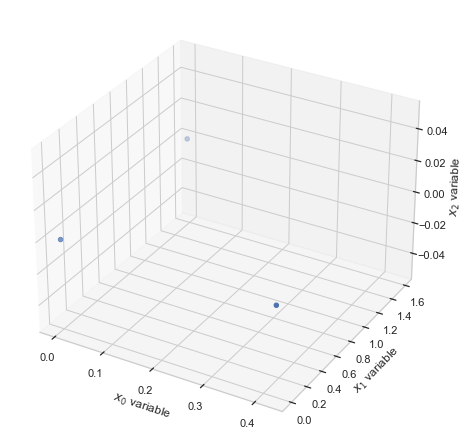

In [6]:
import seaborn as sns
from pylab import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

sns.set_style("whitegrid", {'axes.grid': False})

fig = plt.figure(figsize=(6, 6))

ax = Axes3D(fig)  # Method 1

x = [0, 0, (np.sqrt(3) + 1) / (3 + 2 * np.sqrt(3))]
y = [0, (np.sqrt(3) + 1) / (np.sqrt(3)), 0]
z = [1 / (np.sqrt(3)), 0, 0]

ax.scatter(x, y, marker='o')
ax.set_xlabel(r'$x_0$ variable')
ax.set_ylabel(r'$x_1$ variable')
ax.set_zlabel(r'$x_2$ variable')

plt.show()

Qui verifico con Wolfram Mathematica che il procedimento sia corretto:

    max{log(x) + log(y) + log(z)|x + y<=1 ∧ x + z<=2}≈-0.954769 at (x, y, z)≈(0.42265, 0.577351, 1.57735)

## Algoritmi per il controllo della congestione

Posso osservare che il problema definito precedentemente è un problema convesso e i vincoli di capacità sono dei vincoli
di simplesso. I vincoli di simplesso li ritroviamo anche nei problemi di ottimizzazione sparsa. Nei problemi di
ottimizzazione sparsa uno dei metodi principali per risolvere questi programmi è l'utilizzo del metodo a *penalty
function*. In pratica invece di considerare i vincoli di capacità come se fossero dei vincoli esterni, io li metto nella
funzione obiettivo attraverso l'uso di una funzione penalità. Se procedo in questo modo ottengo: <br>
$\displaystyle max_{x \ge 0} \sum_{i \in \overline{S}} U_i(x_i) - \sum_{l \in \overline{L}} \int_{0}^{\sum_{i \in S_l} x_i} p_l(x)\,dx $

La funzione $ p_l(x) $ denota il *price* del collegamento, cioè il costo a cui vengo sottoposto per attraversare quel
collegamento e $ c_l $ è la sua capacità. Attenzione per i vincoli di conservazione in una rete di flusso a divergenza
nulla bisogna fare attenzione al fatto che il *price* del link $ l $ è funzione del tasso di arrivo *aggregato* cioè
faccio un taglio attorno al nodo e sommo su tutti i flussi che attraversano quel taglio.

Nel libro di [Srikant](https://dl.acm.org/doi/book/10.5555/984116) l'autore dimostra come le condizioni necessarie di
ottimalità siano le seguenti: $\displaystyle U_i'(x_i) - \sum_{l \in L_i}p_l(\sum_{r \in S_l}x_r) = 0 $,
$i\in \overline{S} $ Dunque posso creare un algoritmo di controllo con un metodo del gradiente, ottenendo: <br>
$\displaystyle \frac{dx_r}{dt} = k_i(x_i)(U_i'(x_i) - \sum_{l \in L_i}p_l(\sum_{r \in S_l}x_r))_{x_i}^{+} $ ,
$i\in \overline{S} $ il simbolo $ [ \circ ]^{+} $ indica la parte positiva, dunque useremo un gradiente proiettato. Questo
algoritmo sempre nel libro di [Srikant](https://dl.acm.org/doi/book/10.5555/984116) viene dimostrato come l'obiettivo sia
una funzione di Lyapunov per il sistema, dunque qualunque traiettoria venga indicata dalla soluzione del mio controllore
sarà asintoticamente stabile. Una verisione semplificata ed implementata di questo controllore è l'algoritmo di
[Kelly](http://www.statslab.cam.ac.uk/~frank/rate.pdf).

Si può ragionare in modo analogo anche con il problema duale. In questa versione ogni collegamento usa il proprio tasso
di arrivo totale e con quello si calcola il prezzo di sé stesso. Questo algoritmo si può intereptare nel seguente modo:
se il tasso totale di arrivi è superiore alla propria capacità, allora incrementa il proprio prezzo secondo una *barrier*
function opportuna, altrimenti decrementa il prezzo. Perché parlare di algoritmi di ottimizzazione duali e primali nel
contesto delle reti? Perché è giusto capire con che logica funzionano gli algoritmi ad oggi usati per la gestione delle
congestioni e del flusso. In modo approssimato si possono classificare in 2 categorie:
* A livello di trasporto come nel TCP NewReno oppure Vegas i quali basano il traffico offerto su dei feedback disponibili
* A livello di rete attraverso meccanismi impliciti come AQM DropTail o RED

In prima approssimazione possiamo dire come l'algoritmo primale ha una legge dinamica per gestire il tasso di invio dalla
sorgente ed una legge statica per generare il prezzo del collegamento, un po' come in TCP. Dall'altra parte possiamo dire
che il problema duale usa una legge statica per gestire il tasso di invio della sorgente ed una legge dinamica
(tempovariante) per assegnare il *price* al collegamento, similmente a come lavora AQM. Giusto per fare un esempio: nei
meccanismi di AQM il prezzo ombra (il *price*) è il $ p_l $ e nel metodo di Floyd e Jacobson la lunghezza della coda viene
usata come stimatore del tasso di congestione del collegamento. In quel caso uso la versione duale dell'algoritmo per
aggiustae il prezzo del collegamento.

Il problema di questi metodi è che sono computazionalmente molto dispensiosi, questo a causa del calcolo all'interno
dell'algoritmo (vedi *steepset descent* nel metodo primale) oppure per il calcolo di uno stimatore per la congestione in
un collegamento (vedi lo stimatore empirico lunghezza del buffer nel AQM).

## Algoritmi centralizzati: metodi SDN

Adesso ci concentriamo su gli algoritmi centralizzati. Questi metodi possono essere di due tipi:
* Centralizzati eseguiti su ogni device (ad esempio Djikstra con OSPF) ogni device manda in flooding *tutto*
* Centralizzati su un unico device, oggetto di questo paragrafo

Un'ultima postilla che faccio sul primo punto è la seguente osservazione: l'algoritmo OSPF con Djikstra è un ottimo
algoritmo di label correcting. Ha una debolezza: ogni device ha bisogno dell'*intera* topologia e quindi ogni device
deve trasmettere un LSA (link state advertisement) in ogni singolo collegamento non bloccato con STP. Ho quindi un numero
di pacchetti che nel peggiore dei casi sarà $ o(n^2) $. Dunque OSPF è il miglior algoritmo che abbiamo a disposizione ma
è molto pesante...

Nel caso degli algoritmi centralizzati in questo documento essi vengono eseguiti tutti